In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.sqrt import GainesSqrt
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "Sobol"

scnt: Parameter containing:
tensor([16.], device='cuda:0')
--- 0.34999990463256836 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0., device='cuda:0')
output error:  tensor(-0.0644, device='cuda:0') tensor(0.5000, device='cuda:0')
input: tensor([[0.9961, 0.3438, 0.8438,  ..., 0.4492, 0.8008, 0.1836]],
       device='cuda:0')
output: tensor([[0.9980, 0.5863, 0.9186,  ..., 0.6702, 0.8949, 0.4285]],
       device='cuda:0')
scnt: Parameter containing:
tensor([[31., 22., 31.,  ..., 25., 29., 19.]], device='cuda:0')
RMSE 0.12564296191444332
MAE 0.0847248
bias 0.061905675


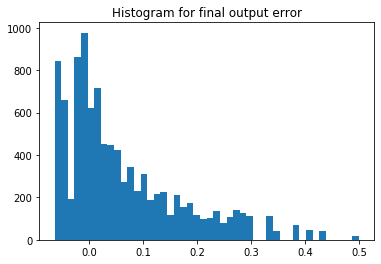

scnt: Parameter containing:
tensor([16.], device='cuda:0')
--- 0.38199758529663086 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.1347, device='cuda:0') tensor(0.4609, device='cuda:0')
input: tensor([[0.0898, 0.0391, 0.2852,  ..., 0.1992, 0.5508, 0.1367]],
       device='cuda:0')
output: tensor([[0.2997, 0.1976, 0.5340,  ..., 0.4463, 0.7421, 0.3698]],
       device='cuda:0')
scnt: Parameter containing:
tensor([[25., 26., 27.,  ..., 27., 29., 25.]], device='cuda:0')
RMSE 0.122535854683223
MAE 0.09453848
bias 0.013688406


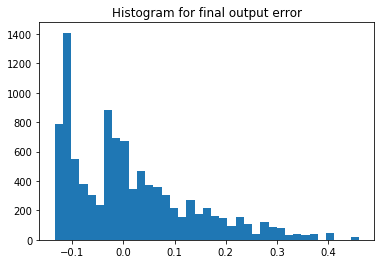

In [4]:
col = 10000
modes = ["unipolar", "bipolar"]
static = True
bitwidth = 8
bstype = torch.float
randtype = torch.float

for mode in modes:
    input = torch.rand(1, col).mul(2**bitwidth).round().div(2**bitwidth).to(device)

    dut_sqrt = GainesSqrt(depth=5, mode=mode, rng="Sobol", rng_dim=2, bstype=torch.float).to(device)

    output = torch.sqrt(input).to(device)

    outPE = ProgressiveError(output, mode=mode).to(device)

    inputPE = ProgressiveError(input, mode=mode).to(device)
    inputSRC = SourceGen(input, bitwidth, mode=mode, randtype=randtype)().to(device)
    inputRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    inputBS = BSGen(inputSRC, inputRNG, bstype).to(device)
    
    with torch.no_grad():
        start_time = time.time()
        print("scnt:", dut_sqrt.scnt)
        for i in range(2**bitwidth):
            input_bs = inputBS(torch.tensor([i]))
            inputPE.Monitor(input_bs)

            out_bs = dut_sqrt(input_bs)
            outPE.Monitor(out_bs)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("input error: ", torch.min(inputPE()[1]), torch.max(inputPE()[1]))
        
        print("output error: ", torch.min(outPE()[1]), torch.max(outPE()[1]))
        
        print("input:", input)
        print("output:", output)

        print("scnt:", dut_sqrt.scnt)
        
        result_pe = outPE()[1].view(-1).cpu().numpy()
        print("RMSE", math.sqrt(sum(result_pe**2)/len(result_pe)))
        print("MAE", np.mean(np.abs(result_pe)))
        print("bias", np.mean(result_pe))
        fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()